In [1]:
!uv pip install -q --system numba-cuda==0.4.0

In [2]:
import numba.cuda as cuda
from numba import config
import numba
config.CUDA_ENABLE_PYNVJITLINK = 1
import matplotlib.pyplot as plt
import numpy as np
import time

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


CPU Image processing

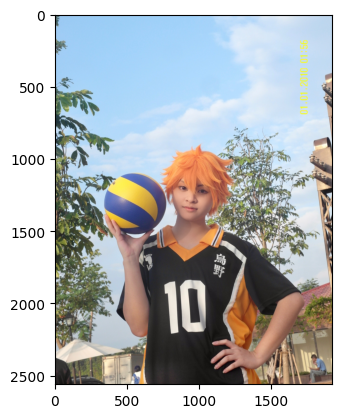

In [4]:
img_path = "/content/drive/MyDrive/Ảnh/Fes/Yosakoi 14 5 22/IMG_8500.JPG"
img = plt.imread(img_path)
plt.imshow(img)

In [5]:
# @cuda.jit
# def grayscale(src, dst):
# # where are we in the input?
#   tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
#   g = np.uint8((src[tidx, 0] + src[tidx, 1] + src[tidx, 2]) / 3)
#   dst[tidx, 0] = dst[tidx, 1] = dst[tidx, 2] = g

In [6]:
# compressed_img = img.reshape(img.shape[0]* img.shape[1], 3)
# compressed_img_cuda = cuda.to_device(compressed_img)
# print(compressed_img_cuda.shape)
# print(type(compressed_img_cuda))
# block_size = 64
# pixel_count = img.shape[0] * img.shape[1]
# grid_size = int(pixel_count/block_size)
# gray_img_cuda =  cuda.device_array((pixel_count, 1), dtype=np.uint8)
# start = time.time()
# grayscale[grid_size, block_size](compressed_img_cuda, gray_img_cuda)
# end = time.time()

# gray_img_host = gray_img_cuda.copy_to_host()
# print(f"CUDA runtime: {end-start}")
# print(gray_img_host.shape)
# gray_img = gray_img_host.reshape(img.shape[0], img.shape[1], 1)
# plt.imshow(gray_img, cmap="gray")

GrayScale (GPU, From Scratch)

In [7]:
# @cuda.jit
# def grayscale2d(src, dst):
# # where are we in the input?
#   tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
#   tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
#   if tidx < src.shape[0] and tidy < src.shape[1]:
#     g = ((src[tidx, tidy, 0] + src[tidx, tidy, 1] + src[tidx, tidy, 2]) / 3)
#     dst[tidx, tidy, 0] = g
#     dst[tidx, tidy, 1] = g
#     dst[tidx, tidy, 2] = g




In [8]:
@cuda.jit
def gaussianblur2D(src, dst, kernel):
# where are we in the input?
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

  if tidx < src.shape[0] and tidy < src.shape[1]:
    half_kernel_h = kernel.shape[0] //2
    half_kernel_w = kernel.shape[1] //2

    blur_pixel_r = 0
    blur_pixel_g = 0
    blur_pixel_b = 0

    for i in range(kernel.shape[0]):
      for j in range(kernel.shape[1]):
        x_i = tidx + i - half_kernel_h
        x_j = tidy + j - half_kernel_w

        if x_i < src.shape[0]  and x_j < src.shape[1]:
          blur_pixel_r += src[x_i, x_j, 0] * kernel[i, j]
          blur_pixel_g += src[x_i, x_j, 1] * kernel[i, j]
          blur_pixel_b += src[x_i, x_j, 2] * kernel[i, j]

    dst[tidx, tidy, 0] = blur_pixel_r
    dst[tidx, tidy, 1] = blur_pixel_g
    dst[tidx, tidy, 2] = blur_pixel_b

Gaussian Blur GPU 2D

(2560, 1920, 3)
<class 'numba.cuda.cudadrv.devicearray.DeviceNDArray'>
1.2121267318725586
[[[142 161 175]
  [125 150 167]
  [122 147 163]
  ...
  [194 191 196]
  [184 181 186]
  [137 134 138]]

 [[163 193 216]
  [154 188 211]
  [153 186 208]
  ...
  [191 208 228]
  [181 197 215]
  [135 147 159]]

 [[169 201 223]
  [162 196 218]
  [159 192 211]
  ...
  [191 213 235]
  [181 201 222]
  [134 150 164]]

 ...

 [[ 86  68  54]
  [ 43  40  34]
  [ 33  34  29]
  ...
  [203 143 108]
  [195 136 104]
  [146 102  78]]

 [[ 80  63  50]
  [ 40  37  31]
  [ 30  31  26]
  ...
  [192 134 102]
  [184 128  98]
  [138  95  74]]

 [[ 58  45  36]
  [ 29  27  22]
  [ 22  22  19]
  ...
  [142  99  76]
  [136  93  72]
  [101  70  54]]]
[[[160 201 231]
  [159 198 227]
  [159 196 223]
  ...
  [191 213 236]
  [192 214 235]
  [192 214 235]]

 [[154 193 222]
  [157 197 223]
  [163 199 225]
  ...
  [192 214 237]
  [192 214 235]
  [193 215 236]]

 [[155 193 216]
  [162 198 220]
  [167 199 220]
  ...
  [193 215 238]
  

/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/cudadrv/devicearray.py:893: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


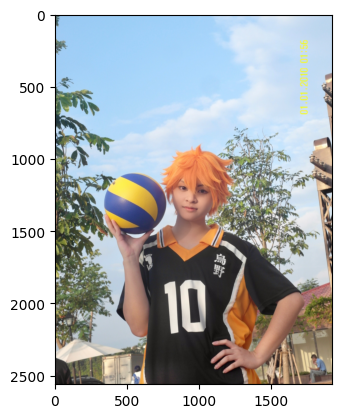

In [9]:
#without shared memory
import math
img_cuda = cuda.to_device(img)
print(img_cuda.shape)
print(type(img_cuda))
gaussian_kernel = np.array([
    [0, 0, 1, 2, 1, 0, 0],
    [0, 3, 13, 22, 13, 3, 0],
    [1, 13, 59, 97, 59, 13, 1],
    [2, 22, 97, 159, 97, 22, 2],
    [1, 13, 59, 97, 59, 13, 1],
    [0, 3, 13, 22, 13, 3, 0],
    [0, 0, 1, 2, 1, 0, 0]
])
gaussian_kernel = gaussian_kernel/np.sum(gaussian_kernel)

block_size = (32, 32)
grid_size = (math.ceil(img.shape[0] / block_size[0]), math.ceil(img.shape[1] / block_size[1]))
gaussian_kernel_gpu = cuda.to_device(gaussian_kernel)
gray_img_cuda =  cuda.device_array((img.shape[0], img.shape[1], 3), dtype = img.dtype)
start = time.time()
gaussianblur2D[grid_size, block_size](img_cuda, gray_img_cuda, gaussian_kernel)
end = time.time()
print(end-start)
gray_img = gray_img_cuda.copy_to_host()
print(gray_img)
print(img)
# gray_img = gray_img_host.reshape(img.shape[0], img.shape[1], 1)

plt.imshow(gray_img)

In [10]:
@cuda.jit
def gaussianblur2D_sharedmem(src, dst, kernel):
# where are we in the input?
  tile = cuda.shared.array((7, 7), kernel.dtype)

  tx = cuda.threadIdx.x
  ty = cuda.threadIdx.y

  tile[tx, ty] = kernel[tx, ty]
  cuda.syncthreads()

  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

  if tidx < src.shape[0] and tidy < src.shape[1]:
    half_kernel_h = tile.shape[0] //2
    half_kernel_w = tile.shape[1] //2

    blur_pixel_r = 0
    blur_pixel_g = 0
    blur_pixel_b = 0

    for i in range(tile.shape[0]):
      for j in range(tile.shape[1]):
        x_i = tidx + i - half_kernel_h
        x_j = tidy + j - half_kernel_w

        if (0<=x_i < src.shape[0])  and (0<=x_j < src.shape[1]):
          blur_pixel_r += src[x_i, x_j, 0] * tile[i, j]
          blur_pixel_g += src[x_i, x_j, 1] * tile[i, j]
          blur_pixel_b += src[x_i, x_j, 2] * tile[i, j]

    dst[tidx, tidy, 0] = blur_pixel_r
    dst[tidx, tidy, 1] = blur_pixel_g
    dst[tidx, tidy, 2] = blur_pixel_b

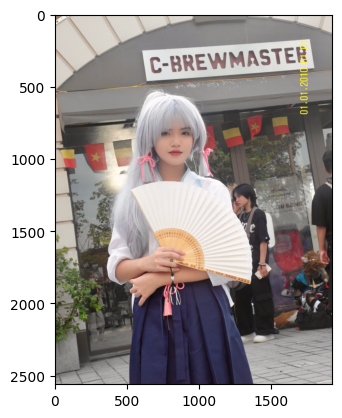

In [11]:
img_path = "/content/drive/MyDrive/Ảnh/Fes/Yosakoi 14 5 22/IMG_8497.JPG"
img = plt.imread(img_path)
plt.imshow(img)

(2560, 1920, 3)
<class 'numba.cuda.cudadrv.devicearray.DeviceNDArray'>
(7, 7)
0.4406716823577881
[[[ 71  56  43]
  [ 96  76  58]
  [102  81  63]
  ...
  [155 150 143]
  [146 142 135]
  [108 105 100]]

 [[ 95  75  57]
  [129 102  78]
  [137 109  83]
  ...
  [209 202 193]
  [197 191 182]
  [146 141 135]]

 [[100  79  60]
  [135 107  81]
  [143 114  86]
  ...
  [220 213 203]
  [208 202 192]
  [155 150 143]]

 ...

 [[113 110 109]
  [151 148 147]
  [159 156 155]
  ...
  [177 173 170]
  [165 162 159]
  [122 119 117]]

 [[109 107 106]
  [147 144 143]
  [155 152 151]
  ...
  [161 158 155]
  [151 148 145]
  [112 109 107]]

 [[ 82  80  80]
  [110 108 107]
  [117 114 113]
  ...
  [117 114 112]
  [110 108 106]
  [ 82  80  79]]]


/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/cudadrv/devicearray.py:893: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


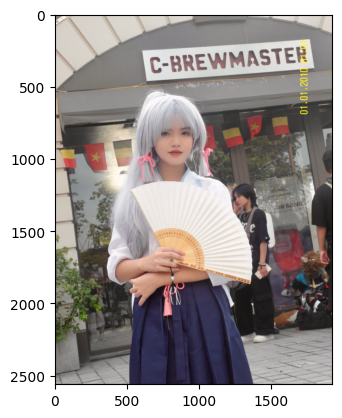

In [12]:
#with shared memory
import math
# img = np.asarray(img, dtype= np.uint8)
img_cuda = cuda.to_device(img)
print(img_cuda.shape)
print(type(img_cuda))
gaussian_kernel = np.array([
    [0, 0, 1, 2, 1, 0, 0],
    [0, 3, 13, 22, 13, 3, 0],
    [1, 13, 59, 97, 59, 13, 1],
    [2, 22, 97, 159, 97, 22, 2],
    [1, 13, 59, 97, 59, 13, 1],
    [0, 3, 13, 22, 13, 3, 0],
    [0, 0, 1, 2, 1, 0, 0]
])
gaussian_kernel = gaussian_kernel/np.sum(gaussian_kernel)
print(gaussian_kernel.shape)
gaussian_kernel_gpu = cuda.to_device(gaussian_kernel)

block_size = (8, 8)
grid_size = (math.ceil(img.shape[0] / block_size[0]), math.ceil(img.shape[1] / block_size[1]))

gray_img_cuda =  cuda.device_array(img.shape, np.uint8)
start = time.time()
gaussianblur2D_sharedmem[grid_size, block_size](img_cuda, gray_img_cuda, gaussian_kernel)
end = time.time()
print(end-start)
gray_img = gray_img_cuda.copy_to_host()
print(gray_img)
# gray_img = gray_img_host.reshape(img.shape[0], img.shape[1], 1)

plt.imshow(gray_img)

In [13]:
import math

gaussian_kernel = np.array([
    [0, 0, 1, 2, 1, 0, 0],
    [0, 3, 13, 22, 13, 3, 0],
    [1, 13, 59, 97, 59, 13, 1],
    [2, 22, 97, 159, 97, 22, 2],
    [1, 13, 59, 97, 59, 13, 1],
    [0, 3, 13, 22, 13, 3, 0],
    [0, 0, 1, 2, 1, 0, 0]
])

gaussian_kernel = gaussian_kernel/np.sum(gaussian_kernel)
def gaussian_blur(img, kernel, block_size, shared_mem = True):
  img_cuda = cuda.to_device(img)
  gaussian_kernel_gpu = cuda.to_device(kernel)

  grid_size = (math.ceil(img.shape[0] / block_size[0]), math.ceil(img.shape[1] / block_size[1]))

  gray_img_cuda =  cuda.device_array(img.shape, img.dtype)
  start = time.time()
  if shared_mem:
    gaussianblur2D_sharedmem[grid_size, block_size](img_cuda, gray_img_cuda, gaussian_kernel)
  else:
    gaussianblur2D[grid_size, block_size](img_cuda, gray_img_cuda, gaussian_kernel)
  end = time.time()
  print(end-start)
  return end - start

import os
import random
block_sizes = [(i, i) for i in range(1, 33)]
imgs_path = "/content/drive/MyDrive/Ảnh/Fes/Yosakoi 14 5 22"
runtimes = []
runtimes_sharedmem = []
for block_size in block_sizes:
  print(f"Block size: {block_size}")
  # print(random.choices(os.listdir(imgs_path)))
  img_name = random.choice(os.listdir(imgs_path))
  if img_name.endswith(".JPG"):
    img = plt.imread(os.path.join(imgs_path, img_name))
    runtimes.append(gaussian_blur(img, gaussian_kernel, block_size, False))
#     runtimes.append(gaussian_blur(img, gaussian_kernel, block_size, True))

Block size: (1, 1)
0.5619871616363525
Block size: (2, 2)
0.10454082489013672
Block size: (3, 3)
0.04678010940551758
Block size: (4, 4)
Block size: (5, 5)
0.01634359359741211
Block size: (6, 6)
0.08211779594421387
Block size: (7, 7)
0.041697025299072266
Block size: (8, 8)
0.036461830139160156
Block size: (9, 9)
0.04275012016296387
Block size: (10, 10)
0.0753326416015625
Block size: (11, 11)
0.0290677547454834
Block size: (12, 12)
0.06871247291564941
Block size: (13, 13)
0.04063129425048828
Block size: (14, 14)
Block size: (15, 15)
0.028983116149902344
Block size: (16, 16)
Block size: (17, 17)
0.02361154556274414
Block size: (18, 18)
0.030835866928100586
Block size: (19, 19)
0.07475161552429199
Block size: (20, 20)
0.03773045539855957
Block size: (21, 21)
0.043862342834472656
Block size: (22, 22)
0.07657027244567871
Block size: (23, 23)
0.03606843948364258
Block size: (24, 24)
0.033583879470825195
Block size: (25, 25)
0.050286054611206055
Block size: (26, 26)
0.025360107421875
Block size

[(1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (32, 32)]


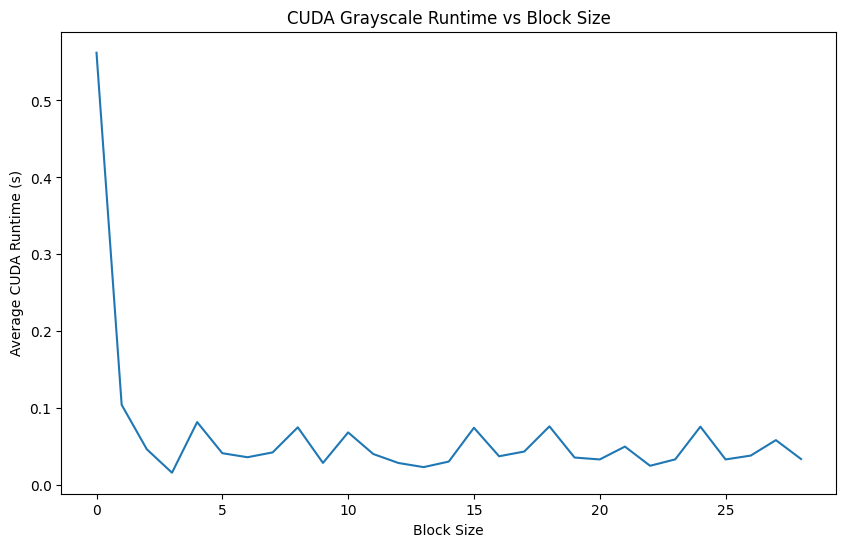

In [19]:
print(block_sizes)
plt.figure(figsize=(10, 6))
plt.plot(runtimes)
# plt.xticks(range(len(block_sizes)), block_sizes)
plt.xlabel("Block Size")
plt.ylabel("Average CUDA Runtime (s)")
plt.title("CUDA Grayscale Runtime vs Block Size")
plt.show()
